In [2]:
!nvidia-smi

Tue Jan 21 04:42:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%pip install datasets seaborn py7zr -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curr

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import zipfile
import os
from datasets import load_dataset


# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
# Load and extract the dataset
def load_and_extract_data(zip_path, extract_to):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Data extracted successfully.")
        for file_name in os.listdir(extract_to):
            if file_name.endswith('.csv'):
                return os.path.join(extract_to, file_name)
        print("No CSV file found in the extracted data.")
        return None
    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

In [6]:
# Load the dataset
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [7]:
# Exploratory Data Analysis (EDA)
def perform_eda(data, text_column, label_column):
    print("Performing EDA...")
    print("\nDataset Information:")
    print(data.info())

    print("\nDataset Description:")
    print(data.describe())

    print("\nChecking for Missing Values:")
    print(data.isnull().sum())

    print("\nLabel Distribution:")
    label_counts = data[label_column].value_counts()
    print(label_counts)

    sns.countplot(x=label_column, data=data)
    plt.title("Label Distribution")
    plt.show()

    print("\nSample Comments:")
    print(data[text_column].head())

In [18]:
# Data pre-processing
def preprocess_text(text):
  if isinstance(text, str):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)
  else:
    # Handle non-string values (e.g., NaN)
    return ""  # or any other suitable replacement

In [9]:
# Preprocess the dataset
def preprocess_dataset(data, text_column):
    data[text_column] = data[text_column].apply(preprocess_text)
    return data

In [10]:
# Split the dataset
def split_data(data, text_column, label_column, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        data[text_column], data[label_column], test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [11]:
# Feature extraction
def vectorize_text(X_train, X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

In [12]:
# Train the model
def train_model(X_train_tfidf, y_train):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_tfidf, y_train)
    return model


In [13]:
# Evaluate the model
def evaluate_model(model, X_test_tfidf, y_test):
    predictions = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return acc, report

In [14]:
# Main pipeline
def main(train_data, validation_data, test_data, text_column, label_column):
    print("Performing EDA on Training Data...")
    perform_eda(train_data, text_column, label_column)

    print("Preprocessing training data...")
    train_data = preprocess_dataset(train_data, text_column)
    validation_data = preprocess_dataset(validation_data, text_column)
    test_data = preprocess_dataset(test_data, text_column)

    print("Vectorizing data...")
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(train_data[text_column])
    X_validation_tfidf = vectorizer.transform(validation_data[text_column])
    X_test_tfidf = vectorizer.transform(test_data[text_column])

    print("Training model...")
    model = train_model(X_train_tfidf, train_data[label_column])

    print("Evaluating on Validation Set...")
    val_acc, val_report = evaluate_model(model, X_validation_tfidf, validation_data[label_column])
    print(f"Validation Accuracy: {val_acc}")
    print(f"Validation Classification Report:\n{val_report}")

    print("Evaluating on Test Set...")
    test_acc, test_report = evaluate_model(model, X_test_tfidf, test_data[label_column])
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Classification Report:\n{test_report}")

In [15]:
#dowload & unzip data

!wget https://github.com/priya-roy/unhealthy-comments-Dataset/raw/refs/heads/main/commentClassification.zip
!unzip commentClassification.zip

--2025-01-21 04:44:21--  https://github.com/priya-roy/unhealthy-comments-Dataset/raw/refs/heads/main/commentClassification.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/priya-roy/unhealthy-comments-Dataset/refs/heads/main/commentClassification.zip [following]
--2025-01-21 04:44:22--  https://raw.githubusercontent.com/priya-roy/unhealthy-comments-Dataset/refs/heads/main/commentClassification.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2722895 (2.6M) [application/zip]
Saving to: ‘commentClassification.zip’

commentClassificati 100%[===================>]   2.60M  --.-KB/s    in 0.06s 

In [16]:
dataset_ucc = load_dataset('commentClassification')
dataset_ucc

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['_unit_id', '_trusted_judgments', 'comment', 'antagonize', 'antagonize:confidence', 'condescending', 'condescending:confidence', 'dismissive', 'dismissive:confidence', 'generalisation', 'generalisation:confidence', 'generalisation_unfair', 'generalisation_unfair:confidence', 'healthy', 'healthy:confidence', 'hostile', 'hostile:confidence', 'sarcastic', 'sarcastic:confidence'],
        num_rows: 35503
    })
    validation: Dataset({
        features: ['_unit_id', '_trusted_judgments', 'comment', 'antagonize', 'antagonize:confidence', 'condescending', 'condescending:confidence', 'dismissive', 'dismissive:confidence', 'generalisation', 'generalisation:confidence', 'generalisation_unfair', 'generalisation_unfair:confidence', 'healthy', 'healthy:confidence', 'hostile', 'hostile:confidence', 'sarcastic', 'sarcastic:confidence'],
        num_rows: 4427
    })
    test: Dataset({
        features: ['_unit_id', '_trusted_judgments', 'commen

Loading datasets...
Performing EDA on Training Data...
Performing EDA...

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35503 entries, 0 to 35502
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   _unit_id                          35503 non-null  int64  
 1   _trusted_judgments                35503 non-null  int64  
 2   comment                           35502 non-null  object 
 3   antagonize                        35503 non-null  int64  
 4   antagonize:confidence             35503 non-null  float64
 5   condescending                     35503 non-null  int64  
 6   condescending:confidence          35503 non-null  float64
 7   dismissive                        35503 non-null  int64  
 8   dismissive:confidence             35503 non-null  float64
 9   generalisation                    35503 non-null  int64  
 10  generalisation:confidence         3

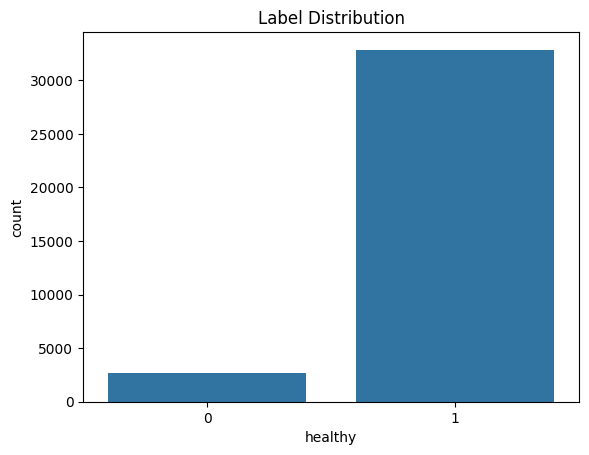


Sample Comments:
0    Three marriages, several bankrupt periods, inh...
1    The sense of entitlement among high school 'jo...
2            So what? He was just stating the obvious.
3    If one is a Con, why yes, one would honk. Loud...
4    Ooohhh... It's Wendy Whiner... making sure to ...
Name: comment, dtype: object
Preprocessing training data...
Vectorizing data...
Training model...
Evaluating on Validation Set...
Validation Accuracy: 0.91597018296815
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.01      0.03       336
           1       0.92      0.99      0.96      4091

    accuracy                           0.92      4427
   macro avg       0.52      0.50      0.49      4427
weighted avg       0.86      0.92      0.89      4427

Evaluating on Test Set...
Test Accuracy: 0.9220338983050848
Test Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.01  

In [19]:
# Run the script
if __name__ == "__main__":
    print("Loading datasets...")
    train_data = pd.read_csv("commentClassification/train.csv")  # Replace with training dataset file path
    validation_data = pd.read_csv("commentClassification/val.csv")  # Replace with validation dataset file path
    test_data = pd.read_csv("commentClassification/test.csv")  # Replace with test dataset file path

    TEXT_COLUMN = "comment"  # Replace with the column name for comments
    LABEL_COLUMN = "healthy"  # Replace with the appropriate label column

    main(train_data, validation_data, test_data, 'comment', 'healthy')
